# Implementation of P2P on AVHRR VHI total data with monthly sampling

first trying with 6 monthly data split



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Implementing pix2pix using arrays directly

In [1]:
import numpy as np
#from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import scipy.misc
import matplotlib
#import xgboost as XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten, Dropout, MaxPooling2D, TimeDistributed, Conv2D, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# data_12 = np.load("/content/drive/MyDrive/Drought_Dataset/AVHRR data/monthly avhrr total data/12monthly_scaled100_avhrr_vhi_1981_2022.npy")
data_12 = np.load(r"E:\Jyoti Shukla - MS/monthly avhrr total data\12monthly_scaled100_avhrr_vhi_1981_2022.npy")
# label_12 = np.load("/content/drive/MyDrive/Drought_Dataset/AVHRR data/monthly avhrr total data/12monthly_scaled100_avhrr_vhi_1981_2022_label.npy")
label_12 = np.load(r"E:\Jyoti Shukla - MS/monthly avhrr total data/12monthly_scaled100_avhrr_vhi_1981_2022_label.npy")
# paired_data_12_norm = np.load("/content/drive/MyDrive/Drought_Dataset/AVHRR data/monthly avhrr total data/12monthly_paired_scaledto1_avhrr_vhi_1981_2022.npz")
paired_data_12_norm = np.load(r"E:\Jyoti Shukla - MS/monthly avhrr total data/12monthly_paired_scaledto1_avhrr_vhi_1981_2022.npz")
# data_12_norm, label_12_norm = paired_data_12_norm['x'], paired_data_12_norm['y']
data_12_norm, label_12_norm = paired_data_12_norm['x'], paired_data_12_norm['y']
print(data_12.shape, label_12.shape, data_12_norm.shape, label_12_norm.shape)
## Splitting into train and test
# train = np.load("/content/drive/MyDrive/Drought_Dataset/AVHRR data/monthly avhrr total data/12monthly_train_paired_scaled100_avhrr_vhi_1981_2022.npz")
train = np.load(r"E:\Jyoti Shukla - MS/monthly avhrr total data/12monthly_train_paired_scaled100_avhrr_vhi_1981_2022.npz")
train_data_12, train_label_12 = train['x'], train['y']
# test = np.load("/content/drive/MyDrive/Drought_Dataset/AVHRR data/monthly avhrr total data/12monthly_test_paired_scaled100_avhrr_vhi_1981_2022.npz")
test = np.load(r"E:\Jyoti Shukla - MS/monthly avhrr total data/12monthly_test_paired_scaled100_avhrr_vhi_1981_2022.npz")
test_data_12, test_label_12 = test['x'], test['y']
print(train_data_12.shape, test_data_12.shape)
np.max(train_data_12), np.min(train_data_12), np.max(test_data_12),np.min(test_data_12)

(519, 192, 128, 1) (519, 192, 128, 1) (519, 192, 128, 1) (519, 192, 128, 1)
(474, 192, 128, 1) (45, 192, 128, 1)


(100.00000000000001, 0.0, 100.00000000000001, 0.0)

# **PIX2PIX USING ARRAY**

In [2]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
import numpy as np
import tensorflow as tf
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, loss_weights=[0.5])
	return model

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model

def define_generator(image_shape=(192,128,)):
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	# e6 = define_encoder_block(e5, 512)
	# e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e5)
	b = Activation('relu')(b)
	# decoder model
	# d1 = decoder_block(b, e7, 512)
	# d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(b, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('sigmoid')(g)
  # define model
	model = Model(in_image, out_image)
	opt = Adam(learning_rate=0.001)
	model.compile(loss='mse', optimizer=opt)
	return model
# def define_generator(image_shape= (190,124,)):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# image input
# 	in_image = Input(shape=image_shape)
# 	# encoder model
# 	e1 = define_encoder_block(in_image, 64, batchnorm=False)
# 	e2 = define_encoder_block(e1, 128)
# 	e3 = define_encoder_block(e2, 256)
# 	e4 = define_encoder_block(e3, 512)
# 	e5 = define_encoder_block(e4, 512)
# 	# e6 = define_encoder_block(e5, 512)
# 	# e7 = define_encoder_block(e6, 512)
# 	# bottleneck, no batch norm and relu
# 	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e5)
# 	b = Activation('relu')(b)
# 	# decoder model
# 	# d1 = decoder_block(b, e7, 512)
# 	# d2 = decoder_block(d1, e6, 512)
# 	d3 = decoder_block(b, e5, 512)
# 	d4 = decoder_block(d3, e4, 512, dropout=False)
# 	d5 = decoder_block(d4, e3, 256, dropout=False)
# 	d6 = decoder_block(d5, e2, 128, dropout=False)
# 	d7 = decoder_block(d6, e1, 64, dropout=False)
# 	# output
# 	g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
# 	out_image = Activation('sigmoid')(g)
# 	# define model
# 	model = Model(in_image, out_image)
#   opt = Adam(learning_rate=0.001)
# 	model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt)
# 	return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	huber_loss = tf.keras.losses.Huber(delta=0.5)
	model.compile(loss=['mse', huber_loss], optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = np.load(filename)
	# unpack arrays
	x1, x2 = data['x'], data['y']
	X1, X2 = x1[:], x2[:]
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	#print(ix)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape[1], patch_shape[2], 1))
	return [X1, X2], y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape[1], patch_shape[2], 1))
	return X, y

In [ ]:
patch = np.ones((1,1,1))
patch

array([[[1.]]])

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples =3):
  #select a sample of input images
  patch = np.ones((1,1,1))
  [X_realA, X_realB],_ = generate_real_samples(dataset, n_samples,patch.shape)
  #generate a batch of fake samples
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, patch.shape)
  #scale all pixels from [-1,-1] to [0,1]
  # X_realA = (X_realA +1)/ 2.0
  # X_realB = (X_realB +1)/2.0
  # X_fakeB = (X_fakeB +1)/2.0
  # for i in range(n_samples):
  #   name = '/content/drive/MyDrive/Drought_Dataset/AVHRR data/monthly_outputs/6monthly compiled 24000/generated_image_'+str(step+1) + str(i)+'.jpg'
  #   #name = 'E:\Jyoti Shukla - MS\monthly outputs\12 monthly 10 epochs/generated_image_'+str(step+1) + str(i)+'.jpg'
  #   matplotlib.image.imsave(name, X_fakeB[i].reshape(192,128))
  #plot real source images
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1+i)
    pyplot.axis('off')
    pyplot.imshow(X_realA[i].reshape(192,128))
  # plot generated target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1+ n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[i].reshape(192,128))
  #plot real target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1+ n_samples*2 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realB[i].reshape(192,128))
  # save plot to file
  # filename1 = '/content/drive/MyDrive/Drought_Dataset/AVHRR data/monthly_outputs/6monthly compiled 24000/plot_%06d.png' % (step+1)
  filename1 = r'E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  # save the generator model
  # filename2 = '/content/drive/MyDrive/Drought_Dataset/AVHRR data/monthly_outputs/6monthly compiled 24000/model_%06d.h5' % (step+1)
  filename2 = r'E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_%06d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' %(filename1, filename2))

In [ ]:
dataset = load_real_samples("/content/drive/MyDrive/Drought_Dataset/AVHRR data/paired_padded_arrays_train_AVHRR_data.npz")
[X_realA, X_realB],y_real = generate_real_samples(dataset, 3,patch.shape)
X_realA.shape

(3, 192, 128, 1)

In [ ]:
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, patch.shape)
X_fakeB.shape, y_fake.shape

((3, 192, 128, 1), (3, 1, 1, 1))

In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=20, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	disc_loss =[]
	disc_loss_real =[]
	gen_loss =[]
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		disc_loss.append(d_loss2)
		disc_loss_real.append(d_loss1)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		gen_loss.append(g_loss)
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % 1000 == 0:
			summarize_performance(i, g_model, dataset)
	return disc_loss_real, disc_loss, gen_loss

In [ ]:
# load image data
dataset = load_real_samples("/Users/Jyoti_Shukla/Documents/Karnataka Dataset/paired_padded_arrays_train_total_AVHRR_data.npz")
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

Loaded (2069, 192, 128, 1) (2069, 192, 128, 1)


C:\Users\Jyoti_Shukla\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
tf.keras.utils.plot_model(g_model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
d_model.output_shape[2]
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [ ]:
trainA, trainB = dataset
bat_per_epo = int(len(trainA) / 1)
	# calculate the number of training iterations
n_steps = bat_per_epo * 10
n_patch = d_model.output_shape
for i in range(150):
  [X_realA, X_realB], y_real = generate_real_samples(dataset, 1, n_patch)
  X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
  d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
  d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
  g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
  print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
  if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)


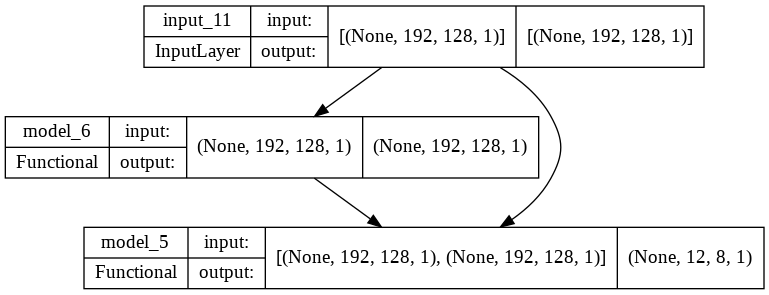

In [ ]:
tf.keras.utils.plot_model(gan_model, show_shapes=True)

In [ ]:
image_shape = dataset[0].shape[1:]
image_shape

(192, 128, 1)

In [ ]:
# load image data
# dataset = load_real_samples("/content/drive/MyDrive/Drought_Dataset/AVHRR data/monthly avhrr total data/6monthly_train_paired_scaledto1_avhrr_vhi_1981_2022.npz")
dataset = load_real_samples("E:\Jyoti Shukla - MS\monthly avhrr total data/12monthly_train_paired_scaledto1_avhrr_vhi_1981_2022.npz")
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
d_model.summary()
g_model.summary()
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
disc_loss_real, disc_loss_gen, gen_loss = train(d_model, g_model, gan_model, dataset)

Streaming output truncated to the last 5000 lines.
>4486, d1[0.365] d2[0.313] g[1.044]
>4487, d1[0.357] d2[0.312] g[1.648]
>4488, d1[0.374] d2[0.383] g[0.792]
>4489, d1[0.288] d2[0.347] g[0.819]
>4490, d1[0.269] d2[0.317] g[0.896]
>4491, d1[0.352] d2[0.293] g[0.876]
>4492, d1[0.315] d2[0.360] g[0.861]
>4493, d1[0.334] d2[0.333] g[0.765]
>4494, d1[0.286] d2[0.364] g[0.785]
>4495, d1[0.276] d2[0.330] g[0.930]
>4496, d1[0.295] d2[0.369] g[0.945]
>4497, d1[0.260] d2[0.373] g[0.843]
>4498, d1[0.406] d2[0.288] g[0.920]
>4499, d1[0.466] d2[0.275] g[0.810]
>4500, d1[0.365] d2[0.354] g[0.747]
>4501, d1[0.352] d2[0.340] g[0.663]
>4502, d1[0.275] d2[0.349] g[0.812]
>4503, d1[0.266] d2[0.371] g[0.847]
>4504, d1[0.445] d2[0.319] g[0.725]
>4505, d1[0.163] d2[0.347] g[0.814]
>4506, d1[0.434] d2[0.320] g[0.756]
>4507, d1[0.301] d2[0.307] g[0.987]
>4508, d1[0.321] d2[0.321] g[0.751]
>4509, d1[0.355] d2[0.353] g[0.744]
>4510, d1[0.191] d2[0.382] g[0.814]
>4511, d1[0.197] d2[0.338] g[0.774]
>4512, d1[0.2

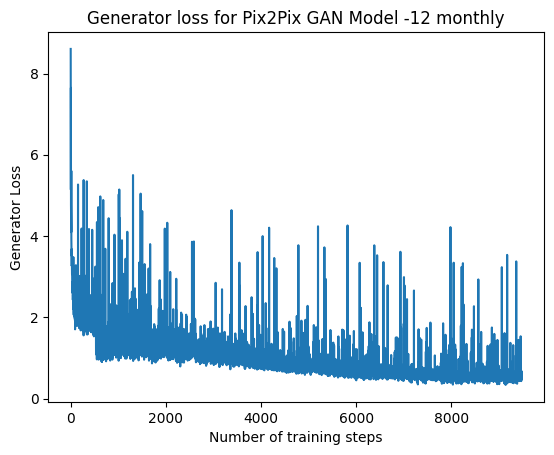

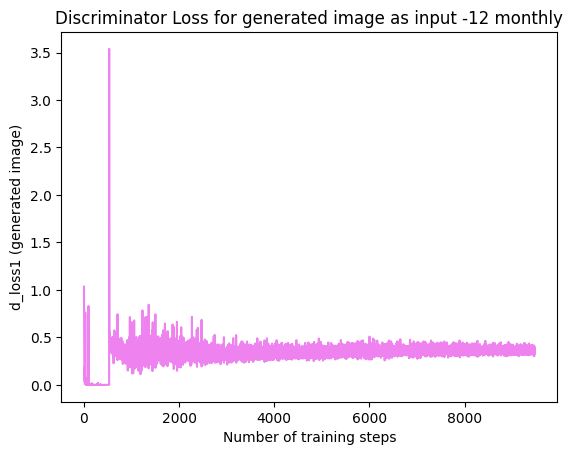

Text(0.5, 1.0, 'Discriminator Loss for real image as input -12 monthly')

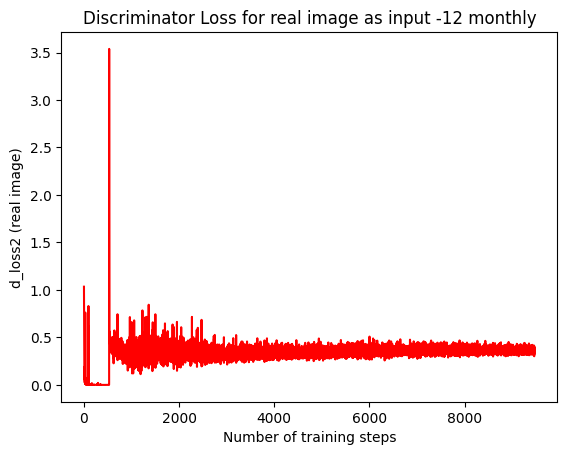

In [ ]:
# when the generator is compiled and 20 epochs/9600 steps 12monthly
import matplotlib.pyplot as plt
plt.plot(gen_loss)
plt.xlabel("Number of training steps")
plt.ylabel("Generator Loss")
plt.title("Generator loss for Pix2Pix GAN Model -12 monthly")
plt.show()
plt.plot(disc_loss_gen,'violet')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss1 (generated image)")
plt.title("Discriminator Loss for generated image as input -12 monthly")
plt.show()
plt.plot(disc_loss_gen,'red')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss2 (real image)")
plt.title("Discriminator Loss for real image as input -12 monthly")

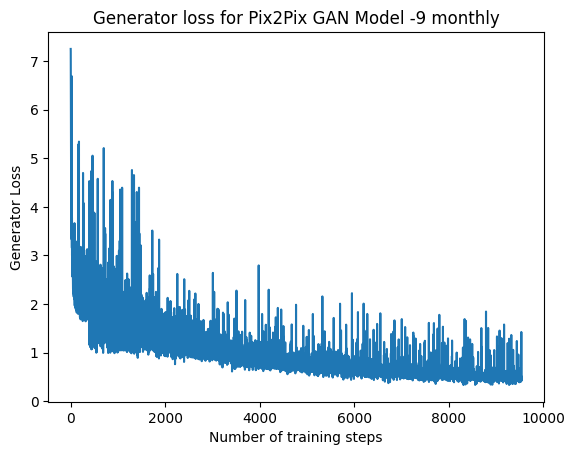

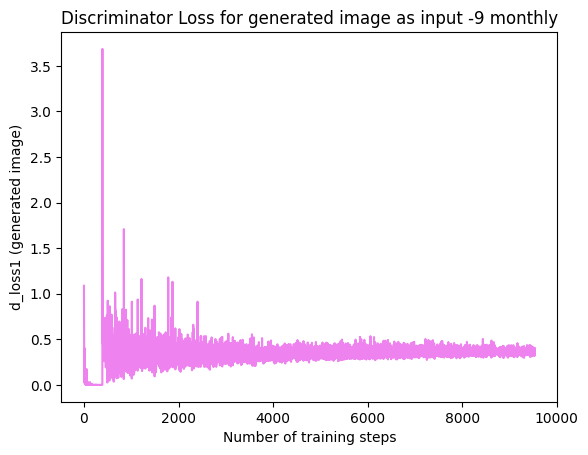

Text(0.5, 1.0, 'Discriminator Loss for real image as input -9 monthly')

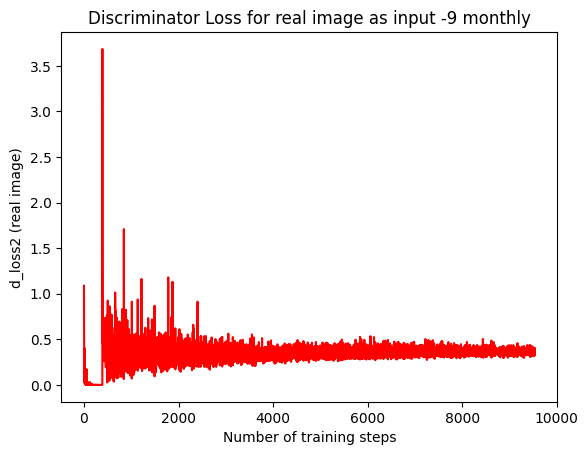

In [ ]:
# when the generator is compiled and 20 epochs/9600 steps 9monthly
import matplotlib.pyplot as plt
plt.plot(gen_loss)
plt.xlabel("Number of training steps")
plt.ylabel("Generator Loss")
plt.title("Generator loss for Pix2Pix GAN Model -9 monthly")
plt.show()
plt.plot(disc_loss_gen,'violet')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss1 (generated image)")
plt.title("Discriminator Loss for generated image as input -9 monthly")
plt.show()
plt.plot(disc_loss_gen,'red')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss2 (real image)")
plt.title("Discriminator Loss for real image as input -9 monthly")

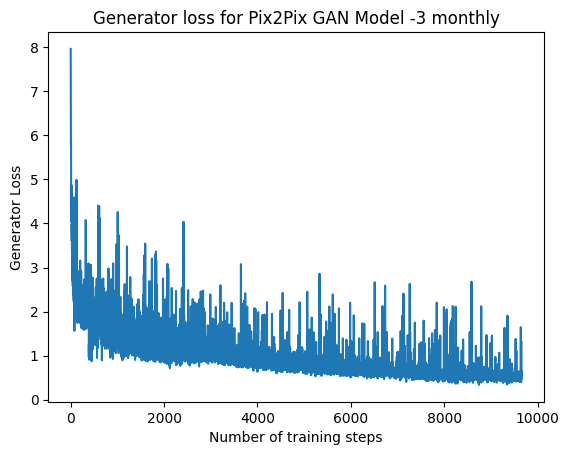

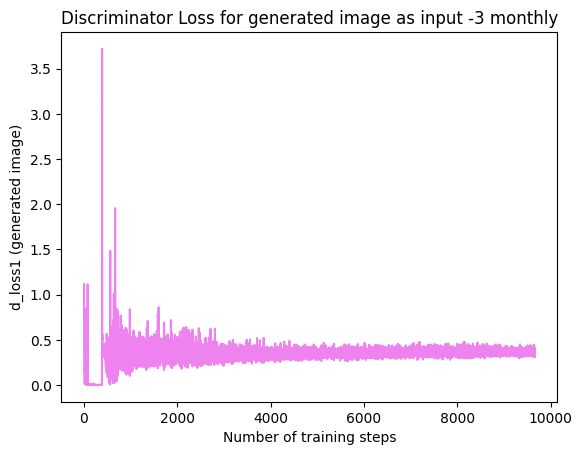

Text(0.5, 1.0, 'Discriminator Loss for real image as input -3 monthly')

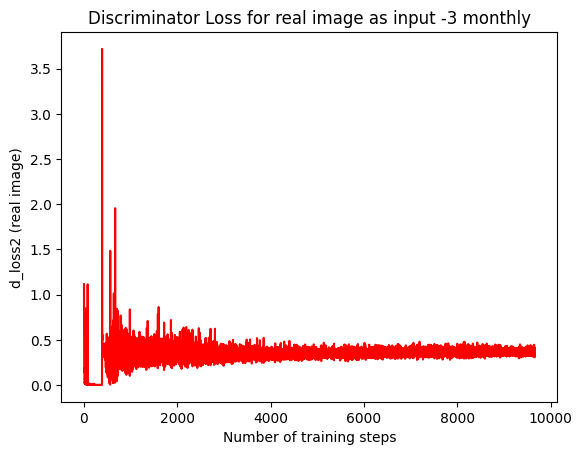

In [ ]:
# when the generator is compiled and 20 epochs/9600 steps 3monthly
import matplotlib.pyplot as plt
plt.plot(gen_loss)
plt.xlabel("Number of training steps")
plt.ylabel("Generator Loss")
plt.title("Generator loss for Pix2Pix GAN Model -3 monthly")
plt.show()
plt.plot(disc_loss_gen,'violet')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss1 (generated image)")
plt.title("Discriminator Loss for generated image as input -3 monthly")
plt.show()
plt.plot(disc_loss_gen,'red')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss2 (real image)")
plt.title("Discriminator Loss for real image as input -3 monthly")

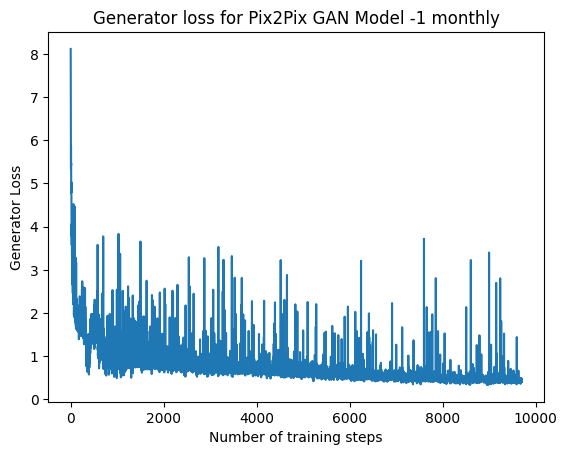

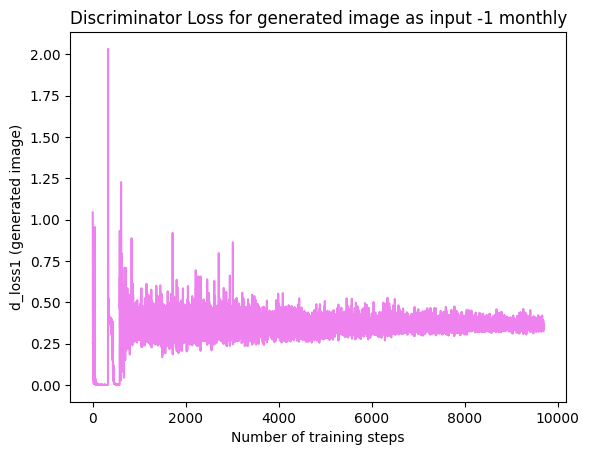

Text(0.5, 1.0, 'Discriminator Loss for real image as input -1 monthly')

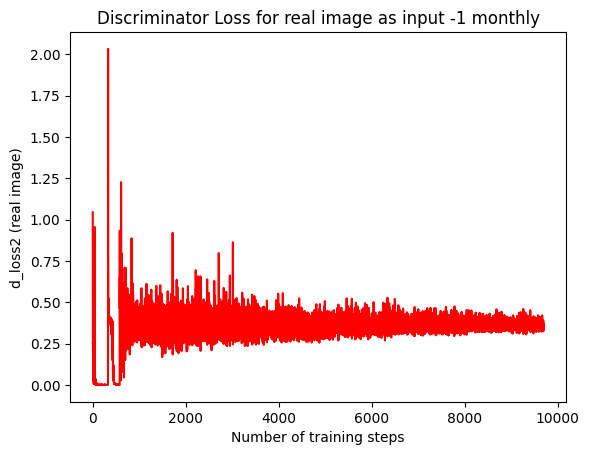

In [ ]:
# when the generator is compiled and 20 epochs/9600 steps 1monthly
import matplotlib.pyplot as plt
plt.plot(gen_loss)
plt.xlabel("Number of training steps")
plt.ylabel("Generator Loss")
plt.title("Generator loss for Pix2Pix GAN Model -1 monthly")
plt.show()
plt.plot(disc_loss_gen,'violet')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss1 (generated image)")
plt.title("Discriminator Loss for generated image as input -1 monthly")
plt.show()
plt.plot(disc_loss_gen,'red')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss2 (real image)")
plt.title("Discriminator Loss for real image as input -1 monthly")

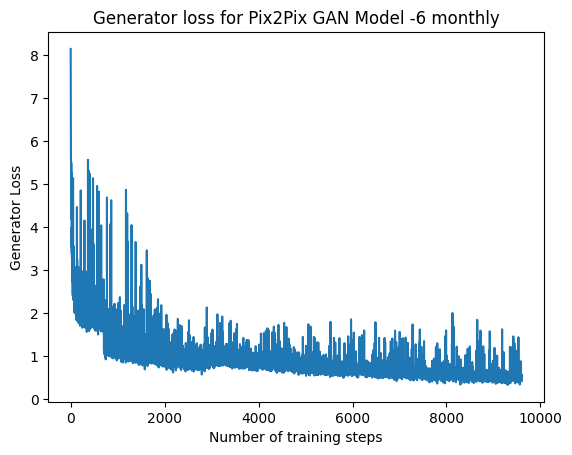

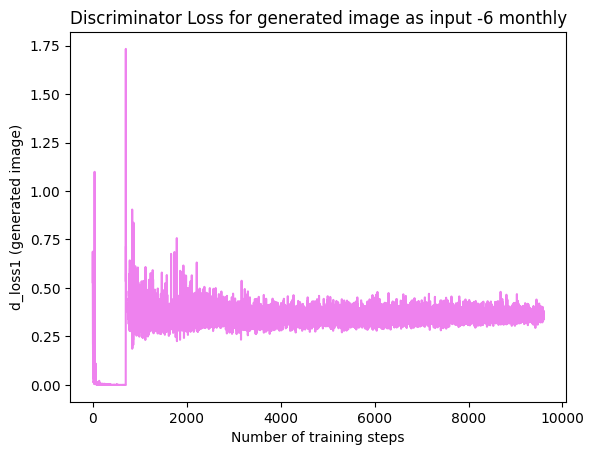

Text(0.5, 1.0, 'Discriminator Loss for real image as input -6 monthly')

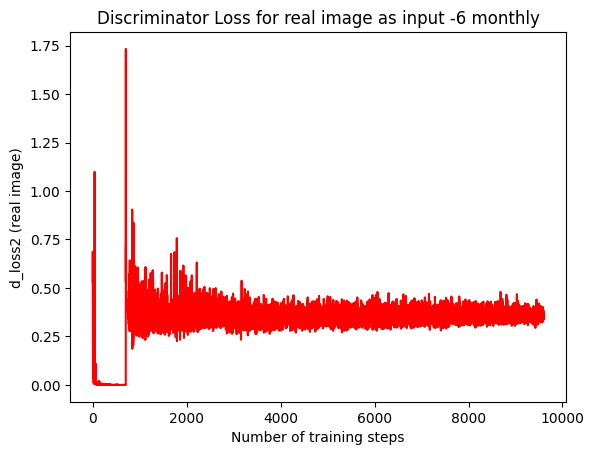

In [ ]:
# when the generator is compiled and 20 epochs/9600 steps
import matplotlib.pyplot as plt
plt.plot(gen_loss)
plt.xlabel("Number of training steps")
plt.ylabel("Generator Loss")
plt.title("Generator loss for Pix2Pix GAN Model -6 monthly")
plt.show()
plt.plot(disc_loss_gen,'violet')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss1 (generated image)")
plt.title("Discriminator Loss for generated image as input -6 monthly")
plt.show()
plt.plot(disc_loss_gen,'red')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss2 (real image)")
plt.title("Discriminator Loss for real image as input -6 monthly")

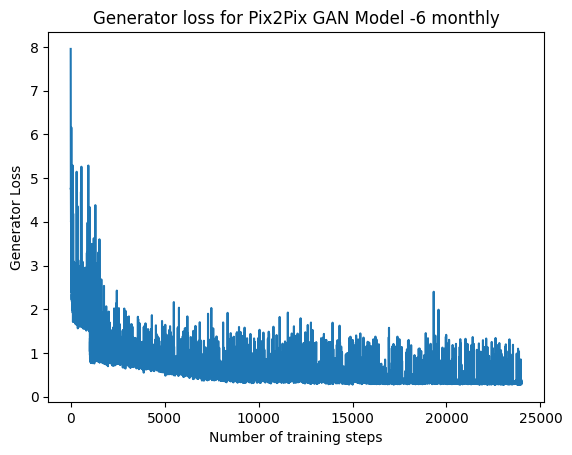

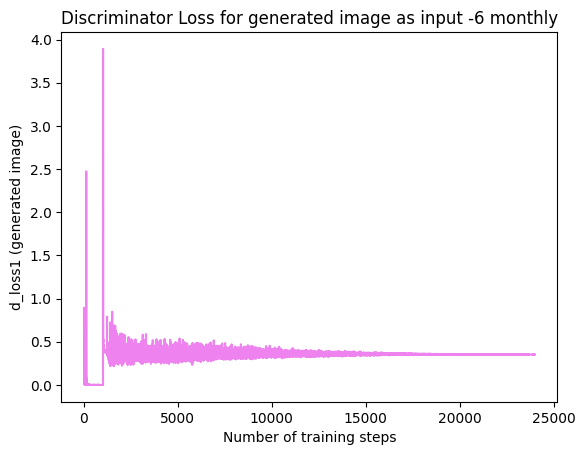

Text(0.5, 1.0, 'Discriminator Loss for real image as input -6 monthly')

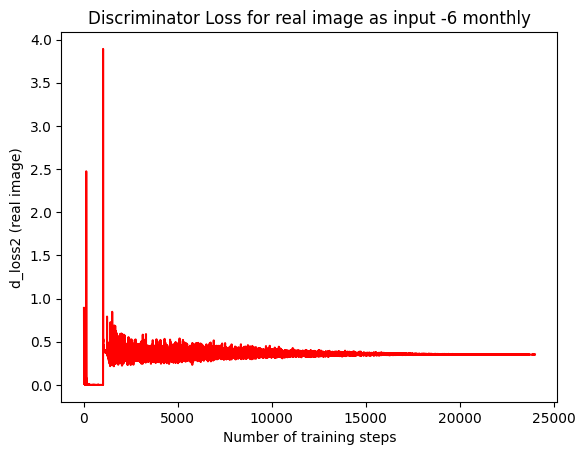

In [ ]:
# when the generator is compiled and 50 epochs/24000 steps
import matplotlib.pyplot as plt
plt.plot(gen_loss)
plt.xlabel("Number of training steps")
plt.ylabel("Generator Loss")
plt.title("Generator loss for Pix2Pix GAN Model -6 monthly")
plt.show()
plt.plot(disc_loss_gen,'violet')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss1 (generated image)")
plt.title("Discriminator Loss for generated image as input -6 monthly")
plt.show()
plt.plot(disc_loss_gen,'red')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss2 (real image)")
plt.title("Discriminator Loss for real image as input -6 monthly")

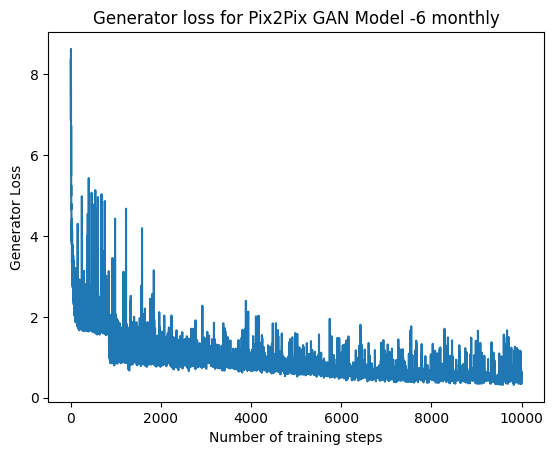

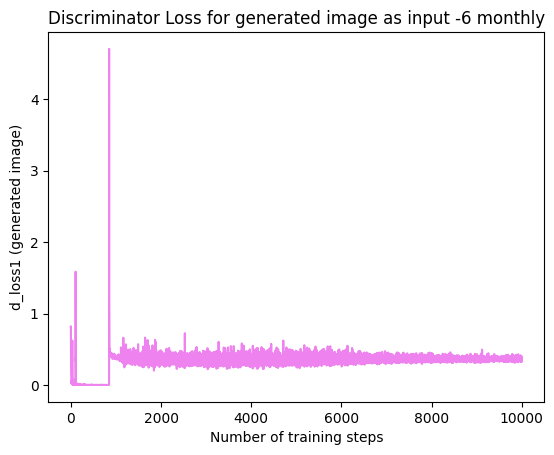

Text(0.5, 1.0, 'Discriminator Loss for real image as input -6 monthly')

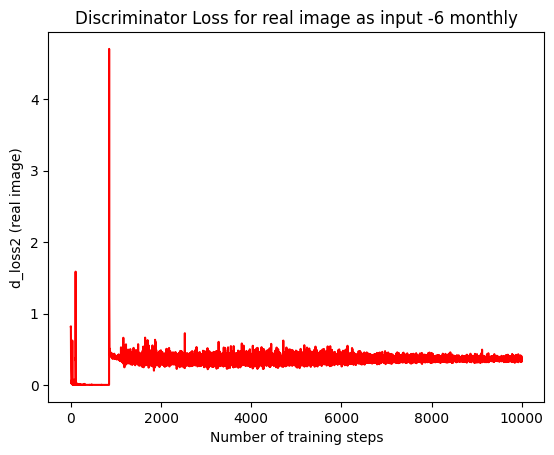

In [ ]:
# when the generator is compiled
import matplotlib.pyplot as plt
plt.plot(gen_loss)
plt.xlabel("Number of training steps")
plt.ylabel("Generator Loss")
plt.title("Generator loss for Pix2Pix GAN Model -6 monthly")
plt.show()
plt.plot(disc_loss_gen,'violet')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss1 (generated image)")
plt.title("Discriminator Loss for generated image as input -6 monthly")
plt.show()
plt.plot(disc_loss_gen,'red')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss2 (real image)")
plt.title("Discriminator Loss for real image as input -6 monthly")

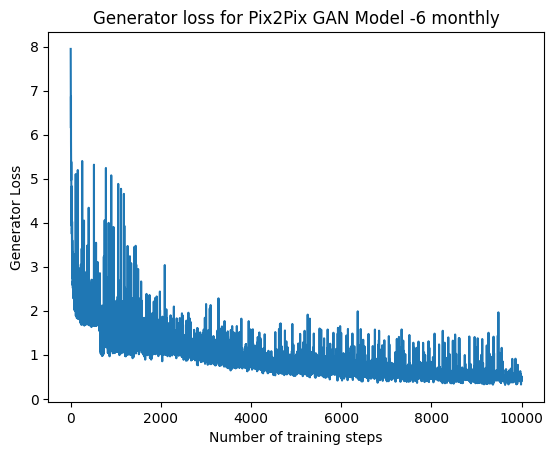

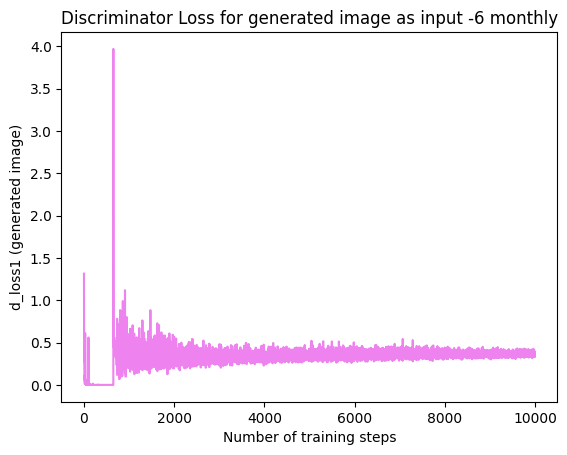

Text(0.5, 1.0, 'Discriminator Loss for real image as input -6 monthly')

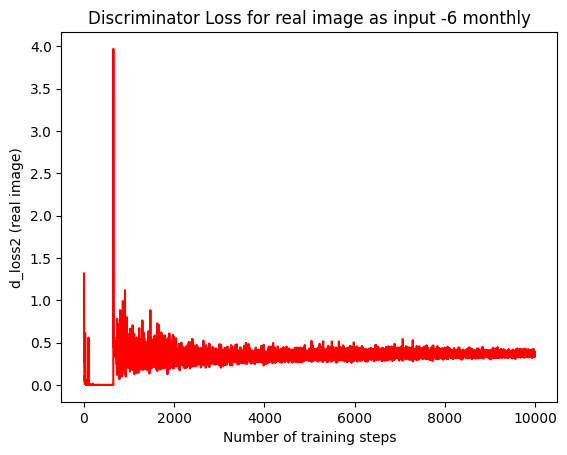

In [ ]:
#when the generator is not compiled
import matplotlib.pyplot as plt
plt.plot(gen_loss)
plt.xlabel("Number of training steps")
plt.ylabel("Generator Loss")
plt.title("Generator loss for Pix2Pix GAN Model -6 monthly")
plt.show()
plt.plot(disc_loss_gen,'violet')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss1 (generated image)")
plt.title("Discriminator Loss for generated image as input -6 monthly")
plt.show()
plt.plot(disc_loss_gen,'red')
plt.xlabel("Number of training steps")
plt.ylabel("d_loss2 (real image)")
plt.title("Discriminator Loss for real image as input -6 monthly")

In [ ]:
# unscaling values
def unscale(mat, VHI_test):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(VHI_test.reshape(192,128))
  unscaled = scaler.inverse_transform(mat.reshape(192,128))
  return unscaled

In [ ]:
def colorcoding(mat):
  for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
      #print(mat[i][j])
      if  mat[i][j] >80:
        mat[i][j] = 255
      # elif (mat[i][j]<80) &(mat[i][j] >70):             # Abnormally Dry
      #   mat[i][j]= 128
      elif (mat[i][j]<80) &(mat[i][j] >60):             # Abnormally Dry
        mat[i][j]= 128
      # elif (mat[i][j]<60) &(mat[i][j] >50):             # Abnormally Dry
      #   mat[i][j]= 64
      elif (mat[i][j]<60) &(mat[i][j] >40):             # Abnormally Dry
        mat[i][j]= 64
      # elif (mat[i][j]<40) &(mat[i][j] >30):             # Abnormally Dry
      #   mat[i][j]= 16
      elif (mat[i][j]<40) &(mat[i][j]>20):              # Moderate drought
        mat[i][j] = 32
      # elif (mat[i][j]<20) & (mat[i][j]>10):             # Severe drought
      #   mat[i][j] = 4
      elif (mat[i][j])<20:                              # Extreme  drought
        mat[i][j]= 0
  return mat

In [ ]:
test_no= np.load("E:\Jyoti Shukla - MS\monthly avhrr total data/6monthly_test_paired_scaledto1_avhrr_vhi_1981_2022.npz")
[X1,X2] = test_no['x'], test_no['y']
print('Loaded', X1.shape, X2.shape)

Loaded (45, 192, 128, 1) (45, 192, 128, 1)


Loaded (45, 192, 128, 1) (45, 192, 128, 1)
[30]
The generated image array through gan is: 
 [[9.3487865e-01 6.0547817e-02 2.8560532e-02 ... 3.1678134e-04
  3.2086522e-04 1.1281876e-02]
 [9.7666159e-02 3.1913321e-03 1.7699582e-03 ... 4.3587228e-05
  2.6451517e-05 8.6234114e-04]
 [3.8238484e-02 1.5621856e-03 1.7999373e-03 ... 2.6401867e-05
  1.1056497e-05 7.2117778e-04]
 ...
 [2.9176479e-02 3.4569283e-03 3.3626603e-03 ... 1.4299501e-05
  4.8166489e-06 2.2862785e-04]
 [1.8086229e-02 2.8142303e-03 1.7685647e-03 ... 5.4866473e-06
  3.5085884e-06 2.1964111e-04]
 [1.0613946e+00 4.5437265e-02 5.5874504e-02 ... 4.8259529e-04
  4.2617170e-04 1.1467922e-02]]

 The expected output was: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


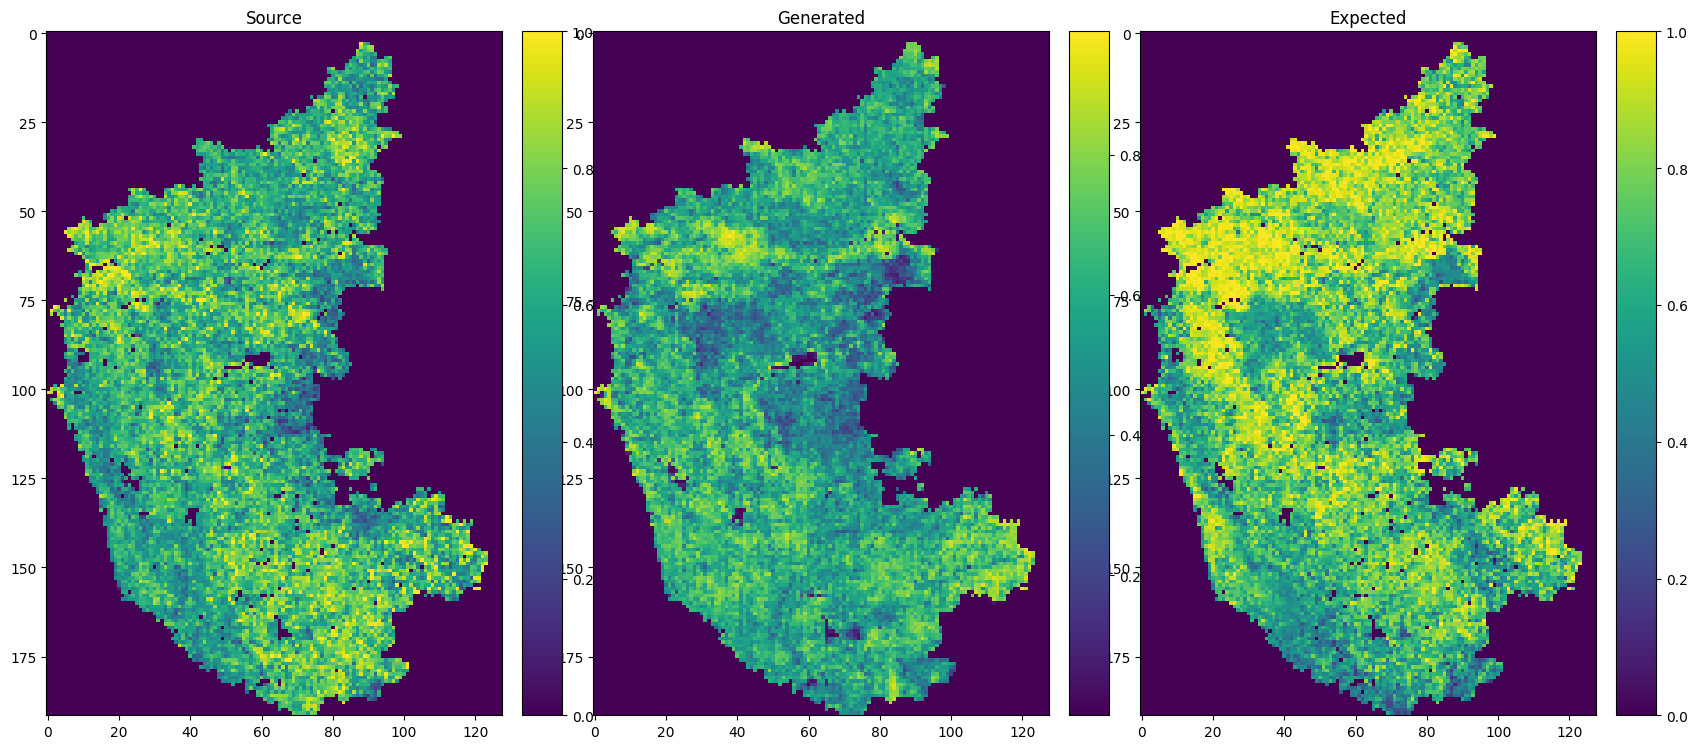


 Unique values of image under test:
 [  0.  32.  64. 128. 255.]
 Unique values of predicted image:
 [  0.  32.  64. 128. 255.] 


 After color-coding the output looks like:



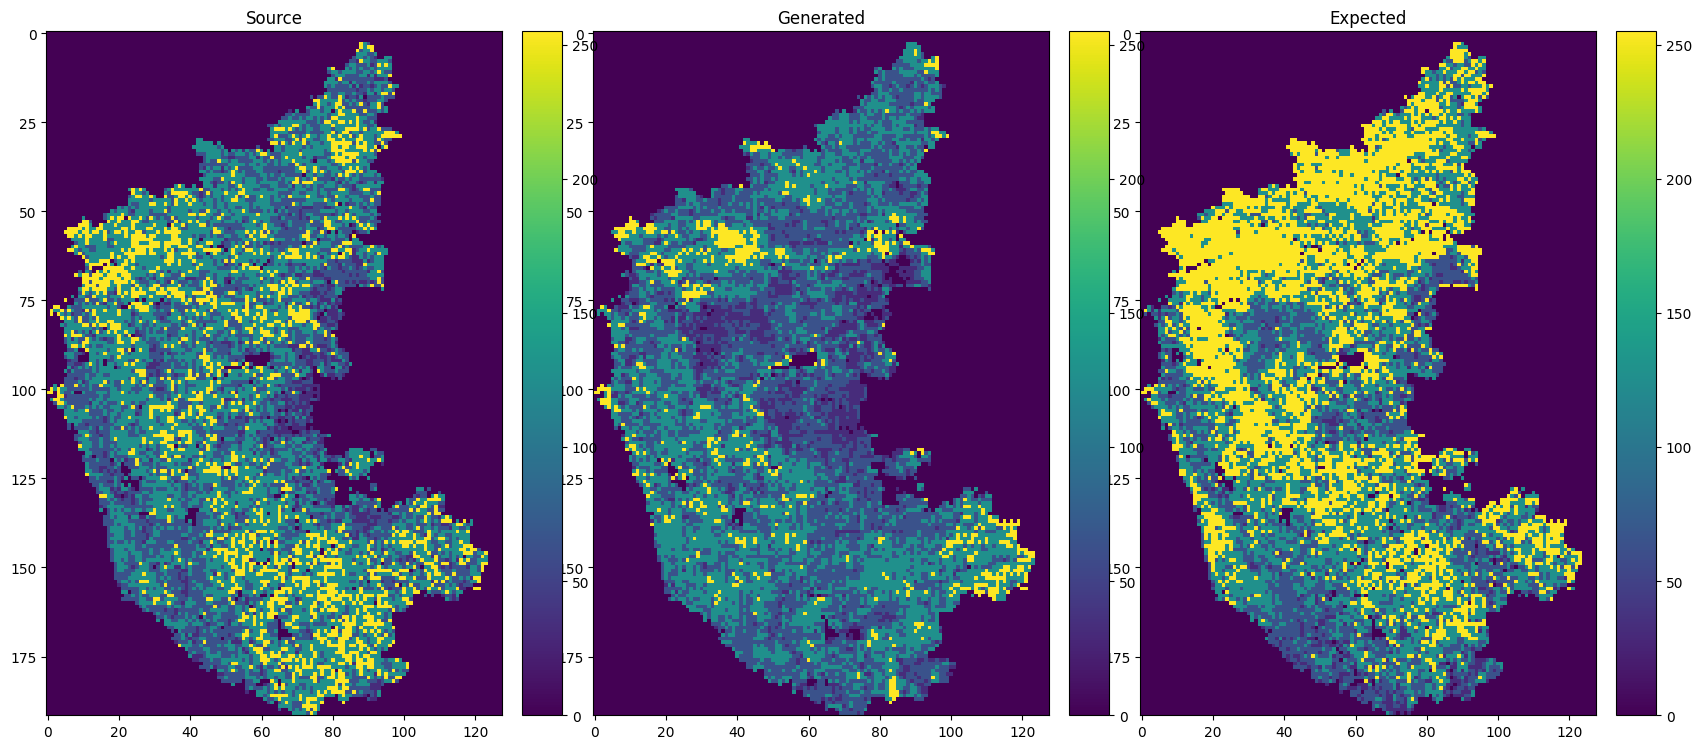

In [ ]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy.random import randint
 
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

#plot source, generated and target images

# def plot_images(src_img, gen_img, tar_img):
#   images = vstack((src_img,gen_img, tar_img))
#   #scale from [-1,1] to [0,1]
#   #images = (images +1)/2.0
#   titles = ['Source','Generated','Expected']
#   #plot images row by
#   # matplotlib.image.imsave("Generated_img.jpg",images[1])
#   # matplotlib.image.imsave("Target_img.jpg",images[2])
#   for i in range(len(images)):
#     #define subplot
#     pyplot.subplot(1,3,1+i)
#     #turn off acis
#     pyplot.axis('off')
#     #plot raw pixel data
#     pyplot.imshow(images[i].reshape(512,512))
#     #show title
#     pyplot.title(titles[i])
#   pyplot.show()
# plot source, generated and target images

def plot_images(src_img, gen_img, tar_img):
  #images = [src_img,gen_img, tar_img]
  images = vstack((src_img,gen_img, tar_img))
  #scale from [-1,1] to [0,1]
  #images = (images +1)/2.0
  titles = ['Source','Generated','Expected']
  #plot images row by
  # matplotlib.image.imsave("Generated_img.jpg",images[1])
  # matplotlib.image.imsave("Target_img.jpg",images[2])
  f, axarr = plt.subplots(1,3, figsize=(20,20))
  for i in range(len(images)):
    #define subplot
    pos = axarr[i].imshow(images[i].reshape(192,128), interpolation = 'None')
    cax = f.add_axes([axarr[i].get_position().x1+0.01,axarr[i].get_position().y0,0.02,axarr[i].get_position().height])
    f.colorbar(pos, ax = axarr[i], cax =cax)
    # pyplot.subplot(1,3,1+i)
    # #turn off acis
    # pyplot.axis('off')
    # #plot raw pixel data
    # pyplot.imshow(images[i].reshape(512,512))
    # #show title
    axarr[i].set_title(titles[i])
  pyplot.show()

 
# load dataset
# [X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_test_total_AVHRR_data.npz')
[X1, X2] = load_real_samples("E:\Jyoti Shukla - MS\monthly avhrr total data/12monthly_test_paired_scaledto1_avhrr_vhi_1981_2022.npz")
print('Loaded', X1.shape, X2.shape)
# load model
#model = load_model('/content/drive/MyDrive/Drought_Dataset/AVHRR data/Output_plots_model_2/model_120000.h5')
model = load_model(r"E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs\model_005000.h5")
# opt = Adam(learning_rate=0.0002, beta_1=0.5)
# model.compile(loss=['binary_crossentropy', 'mse'], optimizer=opt, loss_weights=[1,100])
# select random example
ix = randint(0, len(X1), 1)
print(ix)
#ix = np.asarray([17])
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = model.predict(src_image)
generated = unscale(gen_image,test_label_12[ix])
print("The generated image array through gan is: \n", generated)
expected = unscale(X2[ix],test_label_12[ix])
print("\n The expected output was: \n",expected)
# plot all three images
plot_images(src_image, gen_image, tar_image)
source = unscale(src_image,test_data_12[ix])
# apply colorcoding
source = colorcoding(source)
test_im = colorcoding(expected)
pred_im = colorcoding(generated)
print("\n Unique values of image under test:\n",np.unique(test_im))
print(" Unique values of predicted image:\n", np.unique(pred_im),"\n")
print("\n After color-coding the output looks like:\n")
plot_images(source.reshape(1,192,128,1), pred_im.reshape(1,192,128,1), test_im.reshape(1,192,128,1))

In [ ]:
# ix = randint(0, len(X1), 1)
# print(ix)
#ix = np.asarray([17])
src_image, tar_image = X1[ix], X2[ix]
expected = unscale(X2[ix],VHI_test[int(ix)+1])
# generate image from source
gen_image = model.predict(src_image)
generated = unscale(gen_image,VHI_test[int(ix)+1])
np.unique(generated), np.unique(expected)

(array([5.190821e-06, 5.616710e-06, 7.229677e-06, ..., 9.447602e+01,
        9.451993e+01, 9.480384e+01], dtype=float32),
 array([  0.        ,   7.        ,   9.53731027, ...,  99.97847045,
        100.        , 100.        ]))

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
pred = generated.reshape(192,128)
y_real = expected.reshape(192,128)
print((pred.reshape(192,128))[70][80],(y_real.reshape(192,128))[70][80])
r2 = r2_score(tar_image.reshape(192,128), gen_image.reshape(192,128))
residual = mse(tar_image.reshape(192,128), gen_image.reshape(192,128))
print(r2,residual)
mse(expected.reshape(192,128), generated.reshape(192,128))

64.0 128.0
0.730049815570412 0.02622882735196924


4964.147298177084

In [ ]:
#@title
def colorcoding(mat):
  for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
      #print(mat[i][j])
      if (mat[i][j])> 40:                             #Normal
        mat[i,j] = (255,0,0) 
      elif (mat[i][j]<40) &(mat[i][j] >30):             # Abnormally Dry
        mat[i,j]= (255,0,255)
      elif (mat[i][j]<30) &(mat[i][j]>20):              # Moderate drought
        mat[i][j] = (0,255,255)
      elif (mat[i,j]<20) & (mat[i][j]>10):             # Severe drought
        mat[i][j] = (0,255,0)
      elif (mat[i,j])<10:                              # Extreme  drought
        mat[i,j]= (0,0,0)
  return mat

In [ ]:
from posixpath import realpath
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
# testing all the images
import matplotlib.pyplot as plt
def plot_images(src_img, gen_img, tar_img,ix):
  images = [src_img,gen_img, tar_img]
  #images = vstack((src_img,gen_img, tar_img))
  #scale from [-1,1] to [0,1]
  #images = (images +1)/2.0
  titles = ['Source','Generated','Expected']
  #plot images row by
  # matplotlib.image.imsave("Generated_img.jpg",images[1])
  # matplotlib.image.imsave("Target_img.jpg",images[2])
  f, axarr = plt.subplots(1,3, figsize=(10,15))
  f.tight_layout(pad=4.0)
  for i in range(len(images)):
    #define subplot
    pos = axarr[i].imshow(images[i].reshape(192,128), cmap = "cubehelix_r", interpolation = 'None')
    cax = f.add_axes([axarr[i].get_position().x1+0.01,axarr[i].get_position().y0,0.02,axarr[i].get_position().height])
    f.colorbar(pos, ax = axarr[i], cax =cax)
    # pyplot.subplot(1,3,1+i)
    # #turn off acis
    # pyplot.axis('off')
    # #plot raw pixel data
    # pyplot.imshow(images[i].reshape(512,512))
    # #show title
    axarr[i].set_title(titles[i]+str(ix))
  pyplot.show()

# load dataset
# load and prepare training images

def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
#[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/paired_padded_arrays_test_AVHRR_data.npz')
[X1, X2] = load_real_samples("E:\Jyoti Shukla - MS\monthly avhrr total data/12monthly_test_paired_scaledto1_avhrr_vhi_1981_2022.npz")
print('Loaded', X1.shape, X2.shape)
# load model
#model = load_model('/content/drive/MyDrive/Drought_Dataset/AVHRR data/Output_plots_model_2/model_120000.h5')
# model = load_model(r"E:\Jyoti Shukla - MS\monthly outputs\6 monthly 10 epochs/model_009000.h5")
model = load_model(r"E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_007000.h5")
# original = []
# predicted = []
# predicted_unscaled_without_colorcode =[]
# R2_score_avhrr_model_015000 =[]
# mae_avhrr_model_015000=[]
# mse_avhrr_model_015000=[]
for ix in range(len(X1)):
  ix = np.asarray([ix])
  src_image, tar_image = X1[ix], X2[ix]
  # generate image from source
  gen_image = model.predict(src_image)
  generated = unscale(gen_image,test_label_12[ix])
  #print("The generated image array through gan is: \n", generated)
  # real input
  real = unscale(X1[ix], test_data_12[ix])
  # plt.imshow(real)
  #expected
  expected = unscale(X2[ix],test_label_12[ix])
  #print("\n The expected output was: \n",expected)
  #generated 
  yreal = tar_image.reshape(192,128)
  pred = gen_image.reshape(192,128)
  # r2 = r2_score(yreal, pred)
  # res = mae(yreal, pred)
  # error = mse(yreal, pred)
  test_gen = colorcoding(generated)
  test_real = colorcoding(real)
  #plt.imshow(test_gen)
  # plot all three images
  test_im = colorcoding(expected)
  # R2_score_avhrr_model_015000.append(r2)
  # mae_avhrr_model_015000.append(res)
  # mse_avhrr_model_015000.append(error)
  # predicted_unscaled_without_colorcode.append(pred.reshape(192,128))
  # original.append(test_im)
  # predicted.append(test_gen)
  # np.save("/Users/Jyoti_Shukla/Documents/pix2pix_outputs_total/model_1_avhrr/R2_score_avhrr_model_041380.npy", R2_score_avhrr_model_015000)
  # np.save("/Users/Jyoti_Shukla/Documents/pix2pix_outputs_total/model_1_avhrr/mae_avhrr_model_041380.npy", mae_avhrr_model_015000)
  # np.save("/Users/Jyoti_Shukla/Documents/pix2pix_outputs_total/model_1_avhrr/mse_avhrr_model_041380.npy", mse_avhrr_model_015000)
  # np.save("/Users/Jyoti_Shukla/Documents/pix2pix_outputs_total/model_1_avhrr/predicted_unscaled_without_colorcoded_model_041380.npy", predicted_unscaled_without_colorcode)
  # test_gen = np.reshape(test_gen,(256,256,1))
  # test_im = np.reshape(test_im,(256,256,1))
  # test_real = np.reshape(test_real,(256,256,1))
  #plt.imshow(test_im)
  plot_images(test_real, test_gen, test_im,ix)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# saving the metrics and predicted outputs
from posixpath import realpath
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
# testing all the images
import matplotlib.pyplot as plt

# load dataset
# load and prepare training images

def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
#[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/paired_padded_arrays_test_AVHRR_data.npz')
[X1, X2] = load_real_samples(r"E:\Jyoti Shukla - MS\monthly avhrr total data/12monthly_test_paired_scaledto1_avhrr_vhi_1981_2022.npz")
print('Loaded', X1.shape, X2.shape)
# load model
# model = load_model(r"E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_009000.h5")
model = load_model(r"E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_007000.h5")
original = []
predicted = []
predicted_unscaled_without_colorcode =[]
R2_score_avhrr_12monthly =[]
mae_avhrr_12monthly=[]
mse_avhrr_12monthly=[]
for ix in range(len(X1)):
  ix = np.asarray([ix])
  src_image, tar_image = X1[ix], X2[ix]
  # generate image from source
  gen_image = model.predict(src_image)
  generated = unscale(gen_image,test_label_12[ix])
  #print("The generated image array through gan is: \n", generated)
  # real input
  real = unscale(X1[ix], test_data_12[ix])
  # plt.imshow(real)
  #expected
  expected = unscale(X2[ix],test_label_12[ix])
  #print("\n The expected output was: \n",expected)
  #generated 
  yreal = tar_image.reshape(192,128)
  pred = gen_image.reshape(192,128)
  r2 = r2_score(yreal, pred)
  res = mae(yreal, pred)
  error = mse(yreal, pred)
  test_gen = colorcoding(generated)
  test_real = colorcoding(real)
  #plt.imshow(test_gen)
  # plot all three images
  test_im = colorcoding(expected)
  R2_score_avhrr_12monthly.append(r2)
  mae_avhrr_12monthly.append(res)
  mse_avhrr_12monthly.append(error)
  predicted_unscaled_without_colorcode.append(pred.reshape(192,128))
  original.append(test_im)
  predicted.append(test_gen)
  np.save(r"E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/R2_score_avhrr_model_12monthly_20epochs.npy", R2_score_avhrr_12monthly)
  np.save(r"E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/mae_avhrr_model_12monthly_20epochs.npy", mae_avhrr_12monthly)
  np.save(r"E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/mse_avhrr_model_12monthly_20epochs.npy", mse_avhrr_12monthly)
  np.save(r"E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/predicted_unscaled_without_colorcoded_model_12monthly_20epochs.npy", predicted_unscaled_without_colorcode)

Loaded (45, 192, 128, 1) (45, 192, 128, 1)


In [ ]:
np.max(R2_score_avhrr_model_015000),R2_score_avhrr_model_015000[49:52], mae_avhrr_model_015000[49:52], mse_avhrr_model_015000[49:52]

(0.9364828564042813,
 [0.9297152639688764, 0.9306392621574464, 0.9283913556793566],
 [0.03843406519108254, 0.03846283993865332, 0.03969139123202996],
 [0.004276431515455762, 0.004242723371759519, 0.004512543666067274])

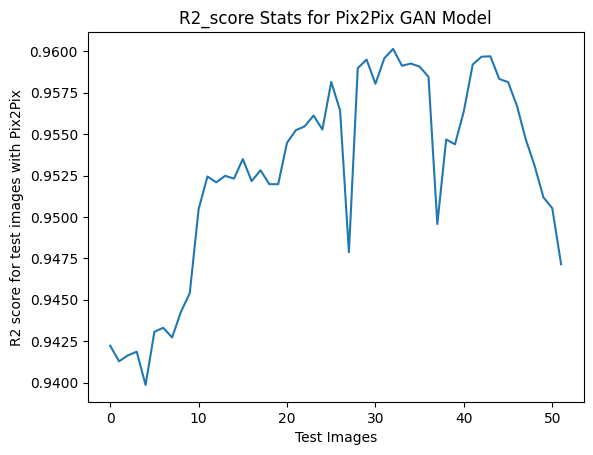

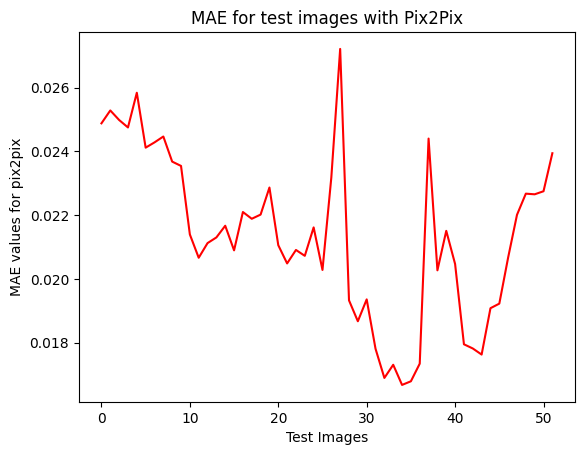

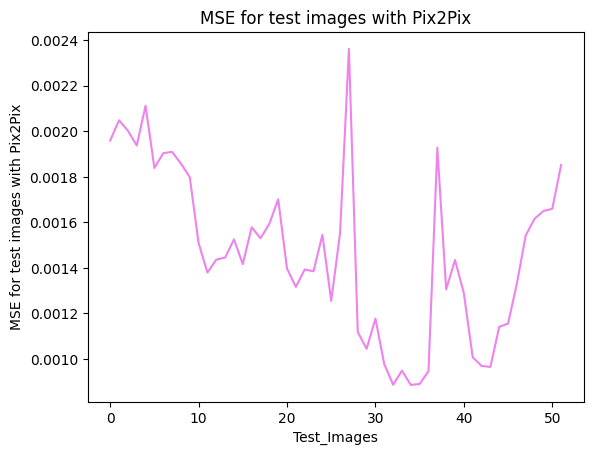

In [ ]:
plt.plot(R2_score_avhrr_model_015000)
plt.xlabel("Test Images")
plt.ylabel("R2 score for test images with Pix2Pix")
plt.title("R2_score Stats for Pix2Pix GAN Model")
plt.show()
plt.plot(mae_avhrr_model_015000,'r')
plt.xlabel("Test Images")
plt.ylabel("MAE values for pix2pix")
plt.title("MAE for test images with Pix2Pix")
plt.show()
plt.plot(mse_avhrr_model_015000,'violet')
plt.xlabel("Test_Images")
plt.ylabel("MSE for test images with Pix2Pix")
plt.title("MSE for test images with Pix2Pix")
plt.show()

In [12]:
import os
path = r"E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/"
dir_list = os.listdir(path)
for file in dir_list:
    if file.endswith(".h5"):
      print(os.path.join(path,file))

E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_001000.h5
E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_002000.h5
E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_003000.h5
E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_004000.h5
E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_005000.h5
E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_006000.h5
E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_007000.h5
E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_008000.h5
E:\Jyoti Shukla - MS\monthly outputs\12 monthly 20 epochs/model_009000.h5


In [14]:
from posixpath import realpath
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from keras.models import load_model
from numpy import load
from numpy import vstack
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy.random import randint

def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
[X1, X2] = load_real_samples("E:\Jyoti Shukla - MS\monthly avhrr total data/12monthly_test_paired_scaledto1_avhrr_vhi_1981_2022.npz")
print(X1.shape,X2.shape)
#[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_test_total_AVHRR_data.npz')
print('Loaded', X1.shape, X2.shape)
# load model
#model = load_model('/content/drive/MyDrive/Drought_Dataset/AVHRR data/Output_plots_model_2/model_030000.h5')
for file in dir_list:
    if file.endswith(".h5"):
      model = load_model(os.path.join(path,file))
      prediction = model.predict(X1)
      # original = []
      # predicted = []
      # predicted_unscaled_without_colorcode =[]
      R2_score_avhrr_model_015000 =[]
      mae_avhrr_model_015000=[]
      mse_avhrr_model_015000=[]
      for ix in range(len(X1)):
        # ix = np.asarray([ix])
        src_image, tar_image = X1[ix], X2[ix]
        # # generate image from source
        # gen_image = model.predict(src_image)
        # generated = unscale(gen_image,VHI_test[int(ix)+1])
        #print("The generated image array through gan is: \n", generated)
        # real input
        # real = unscale(X1[ix], VHI_test[int(ix)])
        #plt.imshow(real)
        #expected
        # expected = unscale(X2[ix],VHI_test[int(ix)+1])
        #print("\n The expected output was: \n",expected)
        #generated 
        yreal = tar_image.reshape(192,128)
        pred = prediction[ix].reshape(192,128)
        r2 = r2_score(yreal, pred)
        res = mae(yreal, pred)
        error = mse(yreal, pred)
        # test_gen = colorcoding(generated)
        # test_real = colorcoding(real)
        #plt.imshow(test_gen)
        # plot all three images
        # test_im = colorcoding(expected)
        R2_score_avhrr_model_015000.append(r2)
        mae_avhrr_model_015000.append(res)
        mse_avhrr_model_015000.append(error)
        # predicted_unscaled_without_colorcode.append(pred.reshape(192,128))

      print("For model", file[7:-3], "mean R2 is:", np.mean(R2_score_avhrr_model_015000) )
      print("For model", file[7:-3], "max R2 is:", np.max(R2_score_avhrr_model_015000))
      print("For model", file[7:-3], "mean mse is:", np.mean(mse_avhrr_model_015000))
      print("For model", file[7:-3], "mean mae is:", np.mean(mae_avhrr_model_015000))




(45, 192, 128, 1) (45, 192, 128, 1)
Loaded (45, 192, 128, 1) (45, 192, 128, 1)
For model 01000 mean R2 is: 0.6746668776796982
For model 01000 max R2 is: 0.7742287681163222
For model 01000 mean mse is: 0.02677056616839024
For model 01000 mean mae is: 0.1001230041234484
For model 02000 mean R2 is: 0.6279456314651877
For model 02000 max R2 is: 0.7844851479813397
For model 02000 mean mse is: 0.03189378111868217
For model 02000 mean mae is: 0.1010733900154831
For model 03000 mean R2 is: 0.5838780465459691
For model 03000 max R2 is: 0.75677719112593
For model 03000 mean mse is: 0.036719260248241826
For model 03000 mean mae is: 0.10923086490916947
For model 04000 mean R2 is: 0.723094999298157
For model 04000 max R2 is: 0.8149888622703739
For model 04000 mean mse is: 0.02186774391169193
For model 04000 mean mae is: 0.08364905376607222
For model 05000 mean R2 is: 0.6888165933795958
For model 05000 max R2 is: 0.8016265748817637
For model 05000 mean mse is: 0.02591765208201645
For model 05000 mea

In [ ]:
from posixpath import realpath
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from keras.models import load_model
from numpy import load
from numpy import vstack
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy.random import randint

def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_test_total_AVHRR_data.npz')
#[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_test_total_AVHRR_data.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('/content/drive/MyDrive/Drought_Dataset/AVHRR data/Pix2Pix_outputs_total/Output_models_1/model_010000.h5')
pred = model.predict(X1)
print(pred.shape)
np.save("/content/drive/MyDrive/Drought_Dataset/AVHRR data/Pix2Pix_outputs_total/Output_models_1/model_10000_predicted_pix2pix_total.npy",pred)

Loaded (52, 192, 128, 1) (52, 192, 128, 1)


2/2 [==============================] - 9s 701ms/step
(52, 192, 128, 1)


In [ ]:
# predicting karnataka region with peninsular training
predicted_peninsular = np.load("/content/drive/MyDrive/Colab Notebooks/Drought_Prediction_codes/Peninsular_AVHRR_codes/model_outputs_peninsular_complete_steps/predicted_ktk_pix2pix_padded.npy")
predicted_peninsular = predicted_peninsular[7:-1]
predicted_peninsular.shape

(52, 192, 128)

In [ ]:
predicted_10000 = np.load("/content/drive/MyDrive/Drought_Dataset/AVHRR data/Pix2Pix_outputs_total/Output_models_1/model_10000_predicted_pix2pix_total.npy")
predicted_10000.shape

(52, 192, 128, 1)

In [ ]:
np.max(predicted_peninsular)

0.97776467

In [ ]:
np.min(predicted_peninsular)

-3.4e+38

In [ ]:
predicted_peninsular[0]

array([[ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [-3.4e+38, -3.4e+38, -3.4e+38, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       ...,
       [-3.4e+38, -3.4e+38, -3.4e+38, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [-3.4e+38, -3.4e+38, -3.4e+38, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [-3.4e+38, -3.4e+38, -3.4e+38, ...,  0.0e+00,  0.0e+00,  0.0e+00]],
      dtype=float32)

In [ ]:
src_image, tar_image = X1[ix], X2[ix]
np.max(src_image), np.max(tar_image)

(1.0, 1.0)

In [ ]:
((X2[0].reshape(192,128)) - predicted_10000[0].reshape(192,128))

array([[-1.1654543e-02, -4.5305374e-04, -3.5285819e-04, ...,
        -4.5367758e-04, -7.1540894e-04, -1.9258922e-02],
       [-5.2414503e-04, -6.3668385e-06, -6.9442990e-06, ...,
        -6.8156905e-06, -1.1893563e-05, -3.1033819e-04],
       [-4.0530806e-04, -9.4353372e-06, -1.0074815e-05, ...,
        -1.0245626e-05, -9.9483386e-06, -5.7063327e-04],
       ...,
       [-4.0991453e-04, -1.7101604e-05, -1.5285354e-05, ...,
        -1.3856863e-05, -1.2236428e-05, -3.9459878e-04],
       [-8.9790468e-04, -4.2361989e-05, -1.3842295e-05, ...,
        -1.7968297e-05, -1.4881945e-05, -8.7784790e-04],
       [-1.2875275e-02, -1.1669141e-03, -4.2408888e-04, ...,
        -1.0827766e-03, -5.4720620e-04, -9.6932920e-03]], dtype=float32)

In [ ]:
r2_score(X2[0].reshape(192,128), predicted_10000[0].reshape(192,128))

0.9335034401737368

In [ ]:
from posixpath import realpath
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from keras.models import load_model
from numpy import load
from numpy import vstack
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy.random import randint

def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
[X1, X2] = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_test_total_AVHRR_data.npz')
R2_score_avhrr_model_015000 =[]
mae_avhrr_model_015000=[]
mse_avhrr_model_015000=[]
for ix in range(len(X1)):
  # ix = np.asarray([ix])
  src_image, tar_image = X1[ix], X2[ix]
  src_image, tar_image = X1[ix], X2[ix]
  # # generate image from source
  # gen_image = model.predict(src_image)
  # generated = unscale(gen_image,VHI_test[int(ix)+1])
  #print("The generated image array through gan for peninsular training data is: \n", generated)
  # real input
  # real = unscale(X1[ix], VHI_test[int(ix)])
  #plt.imshow(real)
  #expected
  # expected = unscale(X2[ix],VHI_test[int(ix)+1])
  #print("\n The expected output was: \n",expected)
  #generated 
  yreal = tar_image.reshape(192,128)
  pred = predicted_peninsular[ix].reshape(192,128)
  r2 = r2_score(yreal, pred)
  res = mae(yreal, pred)
  error = mse(yreal, pred)
  # test_gen = colorcoding(generated)
  # test_real = colorcoding(real)
  #plt.imshow(test_gen)
  # plot all three images
  # test_im = colorcoding(expected)
  R2_score_avhrr_model_015000.append(r2)
  mae_avhrr_model_015000.append(res)
  mse_avhrr_model_015000.append(error)
  # predicted_unscaled_without_colorcode.append(pred.reshape(192,128))

print("mean R2 for peninsular training data is:", np.mean(R2_score_avhrr_model_015000) )
print("max R2 for peninsular training data is:", np.max(R2_score_avhrr_model_015000))
print("mean mse for peninsular training data is:", np.mean(mse_avhrr_model_015000))
print("mean mae for peninsular training data is:", np.mean(mae_avhrr_model_015000))

mean R2 for peninsular training data is: -inf
max R2 for peninsular training data is: -inf
mean mse for peninsular training data is: inf
mean mae for peninsular training data is: inf


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:805: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:805: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/skl

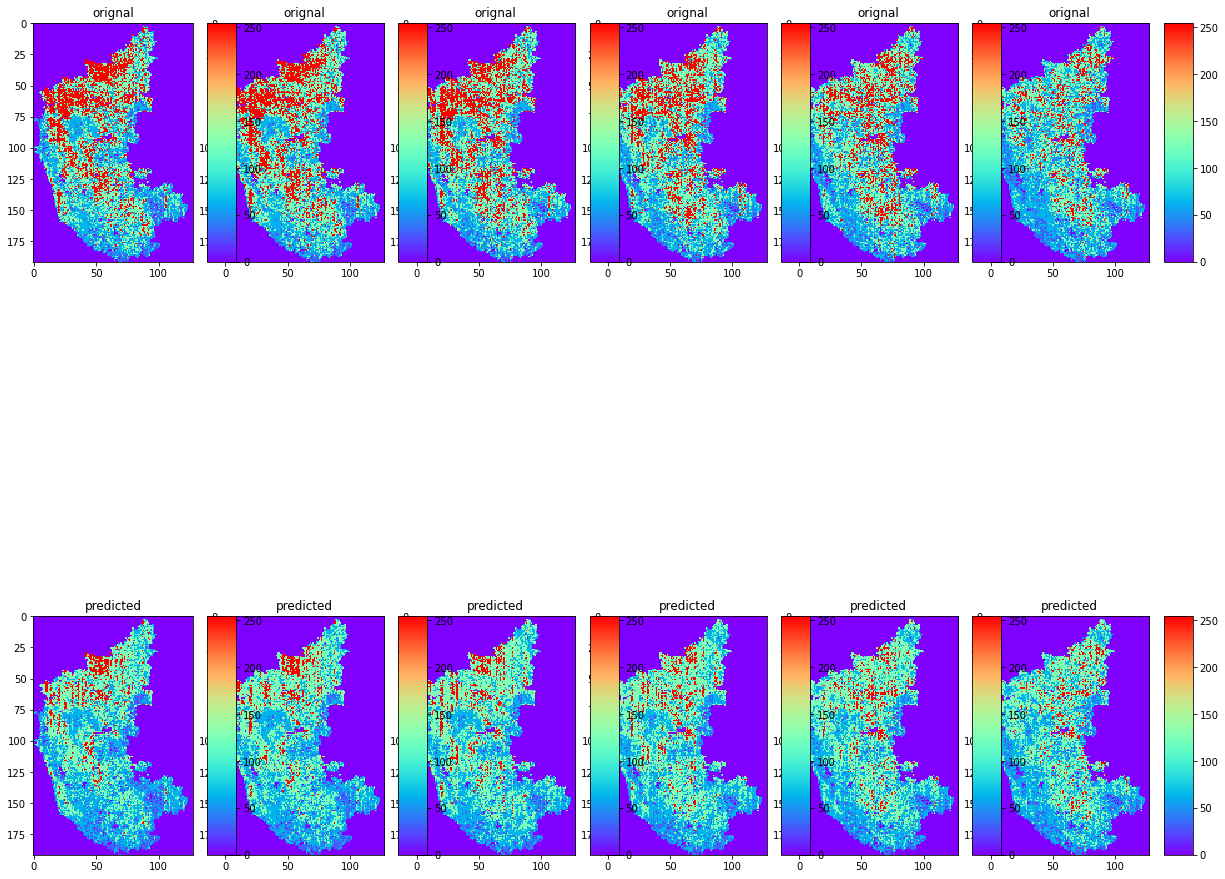

In [ ]:
f, axarr = plt.subplots(2,6, figsize=(20,20))
#axarr = axarr.ravel()

for i in range(2):
   for j in range(6):
     #print(i,j)
     if i == 0:
       pos= axarr[i,j].imshow(original[j],cmap='rainbow',interpolation='None')
       axarr[i,j].set_title('orignal')
       cax = f.add_axes([axarr[i,j].get_position().x1+0.01,axarr[i,j].get_position().y0,0.02,axarr[i,j].get_position().height])
       f.colorbar(pos, ax=axarr[i,j], cax= cax)
     else:
       neg= axarr[i,j].imshow(predicted[j], cmap='rainbow', interpolation='None')
       axarr[i,j].set_title('predicted')
       cax = f.add_axes([axarr[i,j].get_position().x1+0.01,axarr[i,j].get_position().y0,0.02,axarr[i,j].get_position().height])
       f.colorbar(neg, ax=axarr[i,j], cax= cax)
plt.show()

# **Inference and conclusion**

1. With MSE as the loss in place of MAE, the best model seems to be on 6930th epoch. the differences are around 1 between generated and original values. however, the visible outcomes are not satisfactory. 

2. With Huber loss, del=0.5, the outputs and values are slightly improved but not much. Output better on multiple epochs; decide according to output results.

3. Attempting to change the model slightly with deleting two 512 layers of encoder and decoder so as to reduce further division of input dimension and keeping the filter size of last output layer of transposed convolution layer as (4,4) instead of (8,8). 



## convlstm + conv3d

In [ ]:
! pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.8 MB/s 


In [ ]:
import numpy as np
#from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import scipy.misc
import matplotlib
#import xgboost as XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten, Dropout, MaxPooling2D,MaxPooling3D, TimeDistributed, Conv2D, LSTM, SimpleRNN, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
import io
import matplotlib.pyplot as plt
import imageio
from sklearn.metrics import r2_score
# from IPython.display import Image, display
# from ipywidgets import widgets, Layout, HBox
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History 
from tensorflow import keras
import tensorflow_addons as tfa

In [ ]:
#data preprocessing

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = np.load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
dataset = load_real_samples("/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_train_total_AVHRR_data.npz")
dataset_test = load_real_samples('/content/drive/MyDrive/Drought_Dataset/AVHRR data/AVHRR_complete_dataset/paired_padded_arrays_test_total_AVHRR_data.npz')
train_dataset, train_labels = dataset[0],dataset[1]
test_dataset, test_labels = dataset_test[0], dataset_test[1]
# Inspect the dataset.
print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))

Training Dataset Shapes: (2069, 192, 128, 1), (2069, 192, 128, 1)
Validation Dataset Shapes: (52, 192, 128, 1), (52, 192, 128, 1)


In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[i+1:end_ix+1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y), n_steps

In [ ]:
x_train, y_train, n_steps = split_sequence(train_dataset, 4)
x_test, y_test, n_steps = split_sequence(test_dataset,4)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (2065, 4, 192, 128, 1), (2065, 4, 192, 128, 1)
Validation Dataset Shapes: (48, 4, 192, 128, 1), (48, 4, 192, 128, 1)


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History 
from tensorflow import keras
import tensorflow_addons as tfa
model= load_model("/content/drive/MyDrive/Drought_Dataset/AVHRR data/convlstm_3d/convlstm_conv3d_AVHRR_total_model_6.h5")
history=np.load('/content/drive/MyDrive/Drought_Dataset/AVHRR data/convlstm_3d/convlstm_conv3d_AVHRR_total_model_6_history.npy',allow_pickle='TRUE').item()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 192, 128,   0         
                             1)]                                 
                                                                 
 conv_lst_m2d (ConvLSTM2D)   (None, None, 192, 128, 1  9856      
                             6)                                  
                                                                 
 group_normalization (GroupN  (None, None, 192, 128, 1  32       
 ormalization)               6)                                  
                                                                 
 conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 192, 128, 6  184576   
                             4)                                  
                                                                 
 group_normalization_1 (Grou  (None, None, 192, 128, 6  128  

In [ ]:
history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])

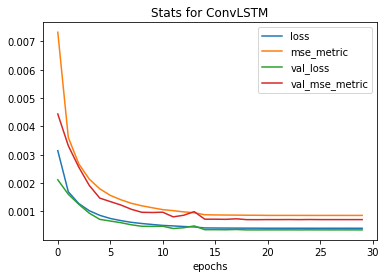

In [ ]:
# Results of updated model

plt.plot(history['loss'])
plt.plot(history['mean_squared_error'])
plt.plot(history['val_loss'])
plt.plot(history['val_mean_squared_error'])

plt.title('Stats for ConvLSTM')
plt.xlabel('epochs')
plt.legend(['loss','mse_metric','val_loss','val_mse_metric'])
plt.show()

In [ ]:
predicted = model.predict(x_test)

2/2 [==============================] - 16s 3s/step


In [ ]:
predicted.shape

(48, 4, 192, 128, 1)